Where are the delivery ‘dead zones’—areas with minimal restaurant coverage?

In [6]:
import os

os.chdir('C:/Users/esram/OneDrive/Desktop/esrabecode/delivery-market-analysis')

os.getcwd()

'C:\\Users\\esram\\OneDrive\\Desktop\\esrabecode\\delivery-market-analysis'

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
conn = sqlite3.connect('data/takeaway.db')

query= """
SELECT l.postalCode,
       l.city,
       COUNT(r.primarySlug) AS restaurant_count,
       MIN(l.latitude) AS latitude,
       MIN(l.longitude) AS longitude
FROM restaurants r
JOIN locations_to_restaurants ltr 
    ON r.primarySlug = ltr.restaurant_id
JOIN locations l 
    ON l.id = ltr.location_id
GROUP BY l.postalCode, l.city
ORDER BY restaurant_count ASC, l.postalCode ASC;
"""

deadzone_city_postal_df = pd.read_sql_query(query, conn)
deadzone_city_postal_df

,postalCode,city,restaurant_count,latitude,longitude
0,8640,Oostvleteren,1,50.933785,2.741783
1,8640,Woesten,1,50.900635,2.790450
2,8647,Noordschote,1,50.955238,2.810721
3,8647,Pollinkhove,1,50.970816,2.733174
4,8647,Reninge,1,50.947662,2.789880
...,...,...,...,...,...
1086,2140,Antwerp,3793,51.195728,4.433730
1087,2600,Antwerp,4735,51.177784,4.411548
1088,2100,Antwerp,5235,51.196622,4.448404
1089,2000,Antwerp,7542,51.205201,4.393356


In [8]:
import folium
from folium.plugins import MarkerCluster


map_center = [deadzone_city_postal_df['latitude'].mean(), deadzone_city_postal_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=10)

marker_cluster = MarkerCluster().add_to(m)

for idx, row in deadzone_city_postal_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5 + row['restaurant_count'],
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"City: {row['city']}<br>"
              f"PostalCode: {row['postalCode']}<br>"
              f"Restaurants: {row['restaurant_count']}"
    ).add_to(marker_cluster)

m.save("dead_zones_map.html")


top 30 bar chart

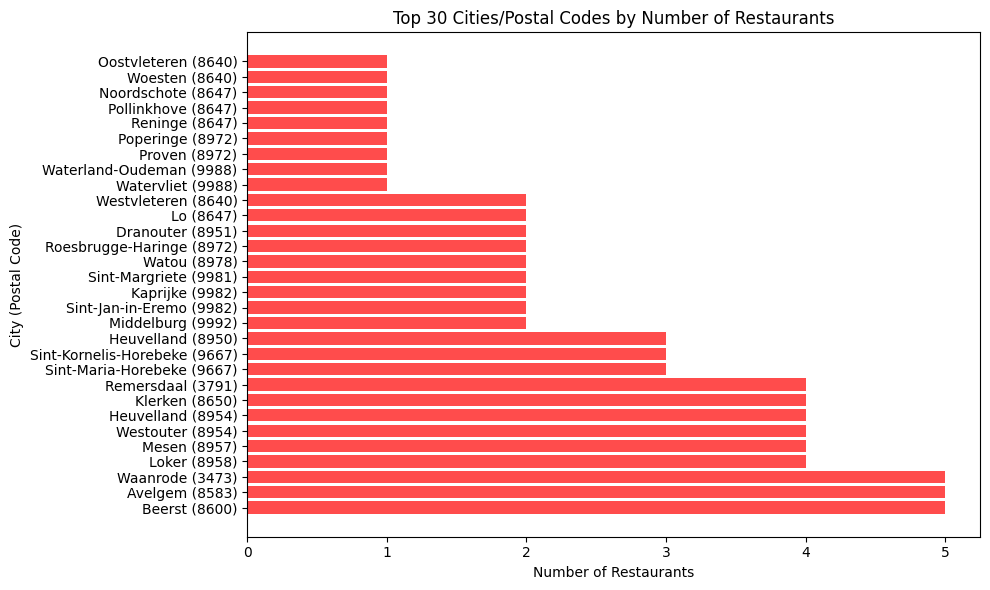

In [11]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('data/takeaway.db')

query_top30 = """
SELECT 
    l.postalCode,
    l.city,
    COUNT(r.primarySlug) AS restaurant_count,
    MIN(l.latitude) AS latitude,
    MIN(l.longitude) AS longitude
FROM restaurants r
JOIN locations_to_restaurants ltr 
    ON r.primarySlug = ltr.restaurant_id
JOIN locations l 
    ON l.id = ltr.location_id
GROUP BY l.postalCode, l.city
ORDER BY restaurant_count ASC
LIMIT 30;
"""

top30_df = pd.read_sql_query(query_top30, conn)

top30_df['label'] = top30_df['city'] + " (" + top30_df['postalCode'].astype(str) + ")"

plt.figure(figsize=(10,6))

plt.barh(top30_df['label'][::-1], top30_df['restaurant_count'][::-1], color='red', alpha=0.7)
plt.xlabel("Number of Restaurants")
plt.ylabel("City (Postal Code)")
plt.title("Top 30 Cities/Postal Codes by Number of Restaurants")
plt.tight_layout()
plt.show()
